In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction, CreateWindowGenerator
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

2022-05-14 17:31:43.307742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 17:31:44.555335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-14 17:31:44.555413: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-14 17:31:44.557209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [2]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Combined"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [3]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    print ("Files found: ")
    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    # Slicing
    print ("\nAfter Slicing: ")
    # train_list = train_list[:3]
    # test_list  = test_list[:3]

    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    return train_list, test_list

Files found: 
	Train count: 350
	Test count : 61

After Slicing: 
	Train count: 350
	Test count : 61


In [20]:
def Predict(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    prediction_dict = {}
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)

    test_df, predictions = MakeSinglePrediction(file_path, model, window)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[:, i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        prediction_dict[label] = (denormed_label, denormed_pred)
    
    return denormed_time, prediction_dict

def ShowPrediction(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        plt.plot(denormed_time, denormed_label)
        plt.plot(denormed_time, denormed_pred)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

In [21]:
train_list, test_list = get_file_list()

pred_window = CreateWindowGenerator(
                    train_list=test_list,
                    test_list=None, eval_list=None,
                    norm_param=NORM_PARAM
                )

Files found: 
	Train count: 350
	Test count : 61

After Slicing: 
	Train count: 350
	Test count : 61


## Importing Model

In [5]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history = LoadModel(model_dir)

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("model_history keys: {}".format(model_history.keys()))

Found 10 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index    Model-name
  [0].   ANN 2022-04-06 06:23:17
  [1].   ANN 2022-04-06 06:35:28
  [2].   ANN 2022-04-13 11:00:28
  [3].   ANN 2022-04-13 11:16:18
  [4].   ANN 2022-04-13 11:49:24
  [5].   ANN 2022-04-13 13:40:18
  [6].   ANN 2022-04-14 12:43:56
  [7].   ANN 2022-04-14 13:42:13
  [8].   ANN 2022-05-11 07:31:41
  [9].   ANN 2022-05-11 07:33:55
You selected model ANN 2022-05-11 07:33:55

model loaded
model history loaded
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


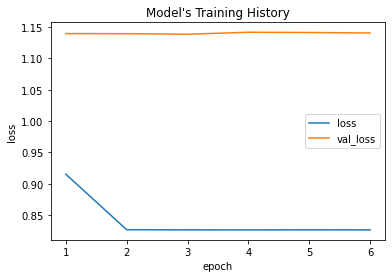

In [6]:
metric = 'loss'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])

plt.xlabel("epoch")
plt.ylabel(metric)
plt.title("Model's Training History")
plt.legend(['loss', 'val_{}'.format(metric)])
plt.show()

## Making Few Predictions

In [7]:
filename = test_list[0]
os.path.basename(filename)

'flight_21882.csv'

timespan: 372.0
mae: 3.8198819160461426


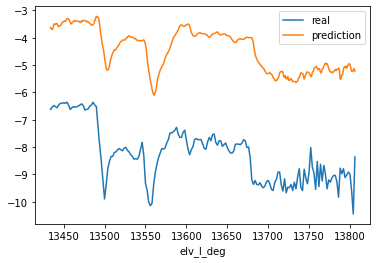

In [22]:
ShowPrediction( 
            "flight_40773.csv",
            model=model,
            window=pred_window
        )

## R2 Results

In [11]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,elv_l_rad
count,61.000000
mean,-28.225757
std,177.684194
min,-1380.034781
25%,-2.533047
50%,-0.071518
75%,0.499208
max,0.799718


In [12]:
r2_df.nlargest(8, columns=labels)

,filename,elv_l_rad
52,flight_12705.csv,0.799718
24,flight_34315.csv,0.798684
42,flight_33373.csv,0.713556
16,flight_39364.csv,0.696420
57,flight_34901.csv,0.685301
9,flight_16534.csv,0.630166
44,flight_31146.csv,0.604263
11,flight_12457.csv,0.594207


In [32]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(10, columns=labels)

,filename,elv_l_rad
0,flight_21882.csv,-1380.034781
32,flight_35911.csv,-181.948097
59,flight_35905.csv,-64.262396
17,flight_23314.csv,-22.144885
1,flight_40773.csv,-13.746893
30,flight_10603.csv,-12.601695
38,flight_24424.csv,-9.697069
25,flight_24692.csv,-7.962426
35,flight_38097.csv,-7.610371
39,flight_40701.csv,-5.899265


filename: flight_12705.csv
timespan: 310.0
mae: 0.3716687560081482


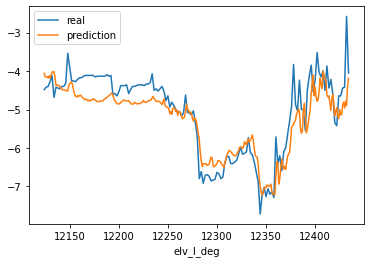

In [23]:
filename_to_predict = "flight_12705.csv"
print ("filename: {}".format(filename_to_predict))
ShowPrediction(filename_to_predict, model, window=pred_window)

min: 201.0
max: 455.0
avg: 331.327868852459


(array([1., 0., 0., 2., 1., 2., 1., 2., 4., 2., 3., 1., 3., 2., 4., 4., 4.,
        4., 1., 3., 3., 3., 3., 2., 1., 1., 2., 0., 1., 1.]),
 array([201.        , 209.46666667, 217.93333333, 226.4       ,
        234.86666667, 243.33333333, 251.8       , 260.26666667,
        268.73333333, 277.2       , 285.66666667, 294.13333333,
        302.6       , 311.06666667, 319.53333333, 328.        ,
        336.46666667, 344.93333333, 353.4       , 361.86666667,
        370.33333333, 378.8       , 387.26666667, 395.73333333,
        404.2       , 412.66666667, 421.13333333, 429.6       ,
        438.06666667, 446.53333333, 455.        ]),
 <BarContainer object of 30 artists>)

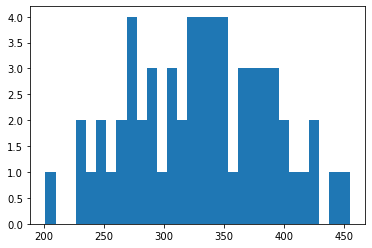

In [15]:
timespans = []
test_dir = ph.GetProcessedPath("Test")
dir_list = os.listdir(test_dir)
for filename in dir_list:
    filepath = os.path.join(test_dir, filename)
    _df = pd.read_csv(filepath)

    timespans.append(_df.loc[_df.shape[0]-1,"time_s"] - _df.loc[0,"time_s"])

print("min: {}".format(min(timespans)))
print("max: {}".format(max(timespans)))
print("avg: {}".format(np.mean(timespans)))

plt.hist(timespans, 30)

In [16]:
bellow_200 = []
for timespan in timespans:
    if timespan < 200:
        bellow_200.append(timespan)

len(bellow_200)

0

Make Predictions

/tmp/ipykernel_8419/2101324599.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


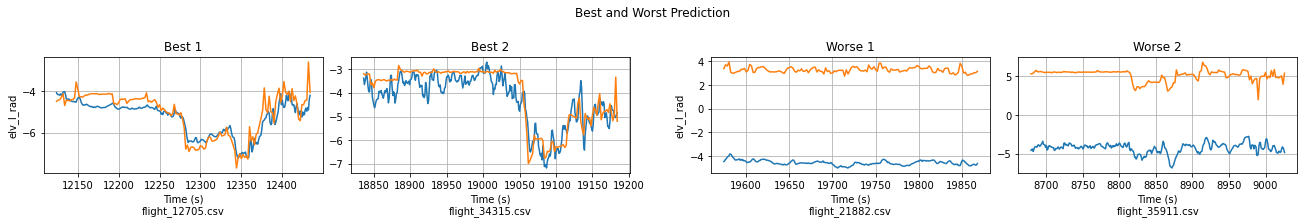

In [45]:
best_list = list(r2_df.nlargest(10, columns=labels).iloc[:2, 0])
worst_list = list(r2_df.nsmallest(10, columns=labels).iloc[:2, 0])
flight_list = best_list + worst_list

important_title = ["Best 1", "Best 2", "Worse 1", "Worse 2"]

fig = plt.figure(constrained_layout=True)

rows = len(G_PARAMS.SEQUENTIAL_LABELS)
cols = 4

gs = fig.add_gridspec(rows, cols)

for j in range(cols):
    big_title = important_title[j]
    flightname = flight_list[j]
    denormed_time, prediction_dict = Predict(
                                        filename=flightname,
                                        model=model,
                                        window=pred_window,
                                        NORM_PARAM=NORM_PARAM
                                    )
    
    for i in range(rows):
        label_index = i % rows
        label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

        denormed_label, denormed_pred = prediction_dict[label]

        ax = fig.add_subplot(gs[i, j])
        ax.plot (denormed_time, denormed_pred)
        ax.plot (denormed_time, denormed_label)
        ax.grid()

        if label_index == 0:
            ax.set_title(big_title)
        if label_index == rows-1:
            ax.set_xlabel("Time (s)" + "\n" + flightname)

        if j == 0 or j == 2:
            ax.set_ylabel('\n'*j + label)

fig.set_size_inches(18/4*cols, 3*rows)
fig.suptitle("Best and Worst Prediction\n")
fig.show()

In [65]:
def PlotManyPredictions(filelist, r: int = 2):
    fig = plt.figure(constrained_layout=True)

    label_count = len(G_PARAMS.SEQUENTIAL_LABELS)
    rows = r
    cols = 4

    gs = fig.add_gridspec(rows*label_count, cols)

    i = 0
    for j in range(cols):
        for i in range(rows):
            flightname = filelist[i*cols + j]
            denormed_time, prediction_dict = Predict(
                                                filename=flightname,
                                                model=model,
                                                window=pred_window,
                                                NORM_PARAM=NORM_PARAM
                                            )

            # Plot every labels for one flight
            for sr in range(label_count):
                label_index = sr
                label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

                denormed_label, denormed_pred = prediction_dict[label]

                ax = fig.add_subplot(gs[i*label_count + sr, j])
                ax.plot (denormed_time, denormed_pred)
                ax.plot (denormed_time, denormed_label)
                ax.grid()

                if label_index == 0:
                    ax.set_title(flightname)
                if label_index == label_count-1:
                    ax.set_xlabel("Time (s)")

                if j == 0 or j == 2:
                    ax.set_ylabel('\n'*j + label)

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Prediction Samples\n")
    fig.show()

/tmp/ipykernel_8419/18902602.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


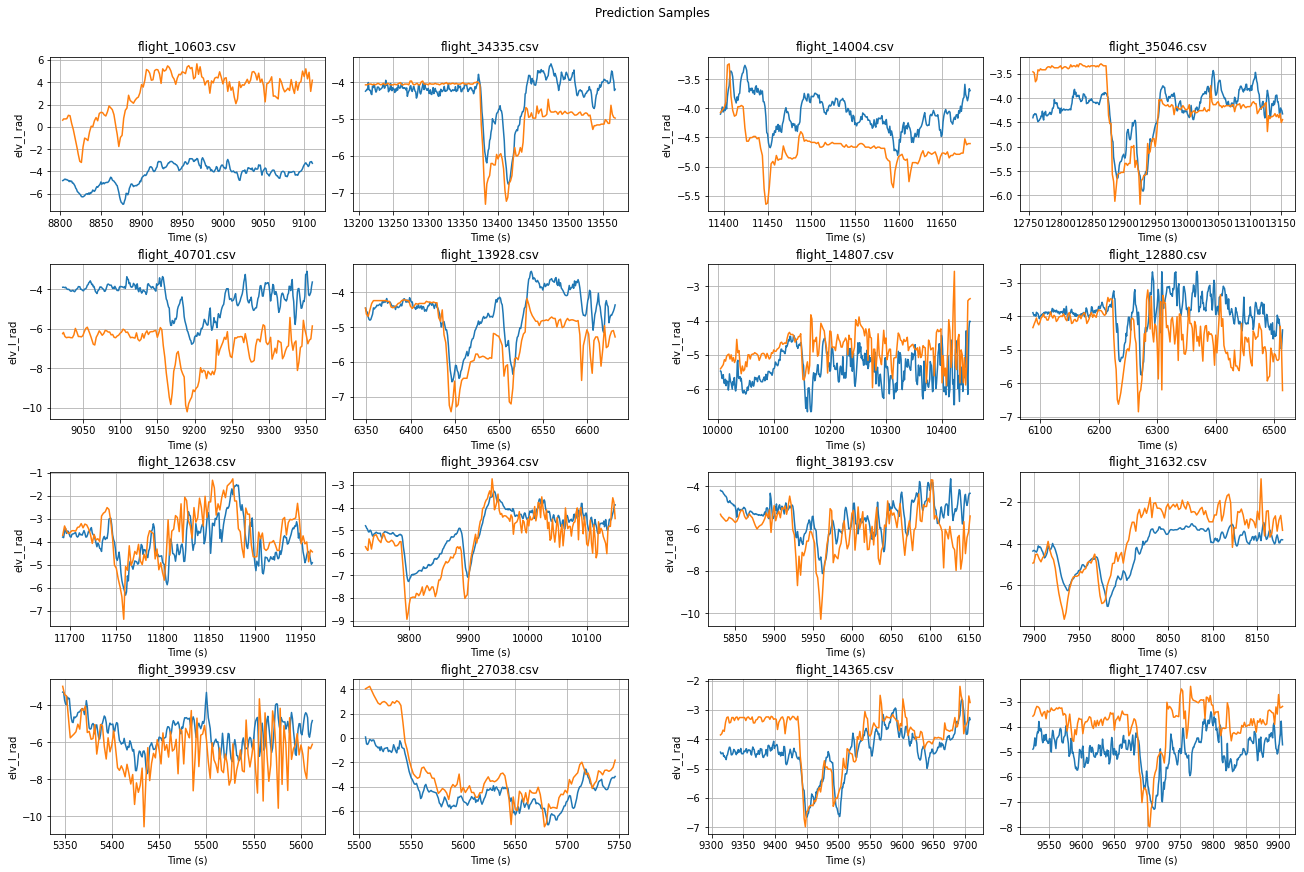

In [67]:
row = 4
col = 4

n = row*col
filelist = list(r2_df.sample(n).iloc[:, 0])

PlotManyPredictions(filelist, r=row)